# Table of Content
* [Read-CSV](#Read-CSV)
* [Categorical-variables-handling](#Categorical-variables-handling)
* [Numeric-variables-handing](#Numeric-variables-handing)
* [Pipeline-to-process-all-variables](#Pipeline-to-process-all-variables)
* [Create-features-and-label](#Create-features-and-label)
* [Split-training-set-and-test-set](#Split-training-set-and-test-set)
* [Logistic-Regression-fitting](#Logistic-Regression-fitting)
* [Hyper-parameter-tunning-for-logistic-regression](#Hyper-parameter-tunning-for-logistic-regression)
* [Decision-Tree-fitting](#Decision-Tree-fitting)
* [Random-Forest-fitting](#Random-Forest-fitting)

In [136]:
import org.apache.spark.ml.feature.StringIndexer
import org.apache.spark.ml.feature.OneHotEncoderEstimator
import org.apache.spark.ml.{Pipeline, PipelineModel}
import org.apache.spark.ml.feature.StandardScaler
import org.apache.spark.mllib.feature.Normalizer
import org.apache.spark.ml.feature.VectorAssembler
import org.apache.spark.ml.classification.LogisticRegression
import org.apache.spark.sql._

import org.apache.spark.ml.feature.StringIndexer
import org.apache.spark.ml.feature.OneHotEncoderEstimator
import org.apache.spark.ml.{Pipeline, PipelineModel}
import org.apache.spark.ml.feature.StandardScaler
import org.apache.spark.mllib.feature.Normalizer
import org.apache.spark.ml.feature.VectorAssembler
import org.apache.spark.ml.classification.LogisticRegression
import org.apache.spark.sql._


# Read CSV

Also invert the label
* 1: bad loan
* 0: good loan

In [164]:
val invertLabel = udf((v: Int) => v match {
    case 0 => 1
    case 1 => 0
})

invertLabel: org.apache.spark.sql.expressions.UserDefinedFunction = UserDefinedFunction(<function1>,IntegerType,Some(List(IntegerType)))


In [166]:
val df = spark.read.format("csv")
  .option("inferSchema", "true")
  .option("header", "true")
  .load("LCLoan_Wrangled.csv")
  .withColumn("loan_status",invertLabel($"loan_status"))

df: org.apache.spark.sql.DataFrame = [loan_amnt: int, term: string ... 63 more fields]


# Categorical variables handling

In [167]:
val categoricalColumns = df.dtypes.filter(column => column._2 == "StringType").map(_._1)

categoricalColumns: Array[String] = Array(term, grade, sub_grade, emp_title, emp_length, home_ownership, verification_status, issue_d, purpose, title, zip_code, addr_state, earliest_cr_line, initial_list_status, last_pymnt_d, last_credit_pull_d, application_type)


In [168]:
val categoricalFeatures = categoricalColumns.flatMap{ name =>
    
    val stringIndexer = new StringIndexer()
      .setInputCol(name)
      .setOutputCol(name + "_index")
      .setHandleInvalid("keep")
    
    val oneHotEncoder = new OneHotEncoderEstimator()
      .setInputCols(Array(name + "_index"))
      .setOutputCols(Array(name + "_vec"))
      .setDropLast(false)
    
    Array(stringIndexer, oneHotEncoder)
}

categoricalFeatures: Array[org.apache.spark.ml.Estimator[_ >: org.apache.spark.ml.feature.OneHotEncoderModel with org.apache.spark.ml.feature.StringIndexerModel <: org.apache.spark.ml.Model[_ >: org.apache.spark.ml.feature.OneHotEncoderModel with org.apache.spark.ml.feature.StringIndexerModel <: org.apache.spark.ml.Transformer with org.apache.spark.ml.param.shared.HasHandleInvalid with org.apache.spark.ml.util.MLWritable] with org.apache.spark.ml.param.shared.HasHandleInvalid with org.apache.spark.ml.util.MLWritable] with org.apache.spark.ml.param.shared.HasHandleInvalid with org.apache.spark.ml.util.DefaultParamsWritable{def copy(extra: org.apache.spark.ml.param.ParamMap): org.apache.spark.ml.Estimator[_ >: org.apache.spark.ml.feature.OneHotEncoderModel with org.apache.spark.ml.feature...


# Numeric variables handing

In [169]:
val numericColumns = df.dtypes.filter(column => column._2 == "IntegerType" || column._2 == "DoubleType").map(_._1)

numericColumns: Array[String] = Array(loan_amnt, int_rate, annual_inc, dti, delinq_2yrs, inq_last_6mths, open_acc, pub_rec, revol_bal, revol_util, total_acc, out_prncp, total_pymnt, total_rec_int, total_rec_late_fee, collection_recovery_fee, last_pymnt_amnt, collections_12_mths_ex_med, policy_code, acc_now_delinq, tot_coll_amt, tot_cur_bal, total_rev_hi_lim, acc_open_past_24mths, chargeoff_within_12_mths, delinq_amnt, mo_sin_old_il_acct, mo_sin_old_rev_tl_op, mo_sin_rcnt_rev_tl_op, mo_sin_rcnt_tl, mort_acc, mths_since_recent_bc, num_accts_ever_120_pd, num_actv_rev_tl, num_bc_sats, num_il_tl, num_rev_accts, num_sats, num_tl_120dpd_2m, num_tl_90g_dpd_24m, num_tl_op_past_12m, pct_tl_nvr_dlq, percent_bc_gt_75, pub_rec_bankruptcies, tax_liens, tot_hi_cred_lim, total_il_high_credit_limit, loa...

In [170]:
val numericColumnsAssembler = new VectorAssembler()
  .setInputCols(numericColumns)
  .setOutputCol("numerical_features")

numericColumnsAssembler: org.apache.spark.ml.feature.VectorAssembler = vecAssembler_4660d8d961f4


In [171]:
val numericColumnsScaler = new StandardScaler()
      .setInputCol("numerical_features")
      .setOutputCol("numerical_features" + "_vec")
      .setWithStd(true)
      .setWithMean(true)

numericColumnsScaler: org.apache.spark.ml.feature.StandardScaler = stdScal_c1fd62652589


# Pipeline to process all variables

In [172]:
val pipeline = new Pipeline()
  .setStages(categoricalFeatures ++ Array(numericColumnsAssembler,numericColumnsScaler) )

val df_transformed = pipeline
  .fit(df)
  .transform(df)

pipeline: org.apache.spark.ml.Pipeline = pipeline_643c7147b130
df_transformed: org.apache.spark.sql.DataFrame = [loan_amnt: int, term: string ... 99 more fields]


# Create features and label

In [173]:
val featureColumns = df_transformed.columns.filter(_.contains("_vec"))

featureColumns: Array[String] = Array(term_vec, grade_vec, sub_grade_vec, emp_title_vec, emp_length_vec, home_ownership_vec, verification_status_vec, issue_d_vec, purpose_vec, title_vec, zip_code_vec, addr_state_vec, earliest_cr_line_vec, initial_list_status_vec, last_pymnt_d_vec, last_credit_pull_d_vec, application_type_vec, numerical_features_vec)


In [175]:
val featureColumnsAssembler = new VectorAssembler()
  .setInputCols(featureColumns)
  .setOutputCol("features")

val df_input = featureColumnsAssembler.transform(df_transformed).withColumn("label",col("loan_status"))

featureColumnsAssembler: org.apache.spark.ml.feature.VectorAssembler = vecAssembler_bc5d983169de
df_input: org.apache.spark.sql.DataFrame = [loan_amnt: int, term: string ... 101 more fields]


# Split training set and test set

In [179]:
val Array(trainingData, testData) = df_input.randomSplit(Array(0.9, 0.1), seed = 1234L)

trainingData: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [loan_amnt: int, term: string ... 101 more fields]
testData: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [loan_amnt: int, term: string ... 101 more fields]


In [180]:
testData.count

res58: Long = 1997


In [181]:
trainingData.count

res59: Long = 18073


# Logistic Regression fitting

In [203]:
val lr = new LogisticRegression()
//   .setMaxIter(100)
//   .setRegParam(0.3)
//   .setElasticNetParam(0.8)

lr: org.apache.spark.ml.classification.LogisticRegression = logreg_30a0562d0fe0


In [204]:
// Fit the model
val lrModel = lr.fit(trainingData)

lrModel: org.apache.spark.ml.classification.LogisticRegressionModel = LogisticRegressionModel: uid = logreg_30a0562d0fe0, numClasses = 2, numFeatures = 10857


## Training Summary

In [205]:
// Extract the summary from the returned LogisticRegressionModel instance trained in the earlier
// example
val trainingSummary = lrModel.binarySummary
val accuracy = trainingSummary.accuracy
val falsePositiveRate = trainingSummary.weightedFalsePositiveRate
val truePositiveRate = trainingSummary.weightedTruePositiveRate
val fMeasure = trainingSummary.weightedFMeasure
val precision = trainingSummary.weightedPrecision
val recall = trainingSummary.weightedRecall
println(s"Accuracy: $accuracy\nFPR: $falsePositiveRate\nTPR: $truePositiveRate\n" +
  s"F-measure: $fMeasure\nPrecision: $precision\nRecall: $recall")

Accuracy: 1.0
FPR: 0.0
TPR: 1.0
F-measure: 1.0
Precision: 1.0
Recall: 1.0


trainingSummary: org.apache.spark.ml.classification.BinaryLogisticRegressionTrainingSummary = org.apache.spark.ml.classification.BinaryLogisticRegressionTrainingSummaryImpl@4062040f
accuracy: Double = 1.0
falsePositiveRate: Double = 0.0
truePositiveRate: Double = 1.0
fMeasure: Double = 1.0
precision: Double = 1.0
recall: Double = 1.0


In [206]:
val roc = trainingSummary.roc
roc.show()
println(s"areaUnderROC: ${trainingSummary.areaUnderROC}")

+--------------------+-------------------+
|                 FPR|                TPR|
+--------------------+-------------------+
|                 0.0|                0.0|
|                 0.0|0.17706666666666668|
|                 0.0|0.27413333333333334|
|                 0.0|             0.3696|
|                 0.0| 0.4650666666666667|
|                 0.0| 0.5605333333333333|
|                 0.0|              0.656|
|                 0.0| 0.7514666666666666|
|                 0.0| 0.8469333333333333|
|                 0.0|             0.9424|
|0.004383257192245956|                1.0|
|0.015434004198049142|                1.0|
|0.026484751203852328|                1.0|
|0.037535498209655516|                1.0|
|  0.0485862452154587|                1.0|
|0.059636992221261884|                1.0|
| 0.07068773922706507|                1.0|
| 0.08173848623286825|                1.0|
| 0.09278923323867144|                1.0|
| 0.10383998024447463|                1.0|
+----------

roc: org.apache.spark.sql.DataFrame = [FPR: double, TPR: double]


In [207]:
roc.createOrReplaceTempView("roc")

In [112]:
! pip install pandas
! pip install matplotlib

     |################################| 10.1MB 30.8MB/s eta 0:00:01
     |################################| 512kB 42.1MB/s eta 0:00:01
     |######################          | 12.1MB 43.4MB/s eta 0:00:01

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |################################| 17.3MB 43.4MB/s eta 0:00:01
     |################################| 13.1MB 21.3MB/s eta 0:00:01
     |################################| 92kB 27.1MB/s eta 0:00:01
     |################################| 71kB 27.1MB/s eta 0:00:01


   FPR       TPR
0  0.0  0.000000
1  0.0  0.177067
2  0.0  0.274133
3  0.0  0.369600
4  0.0  0.465067


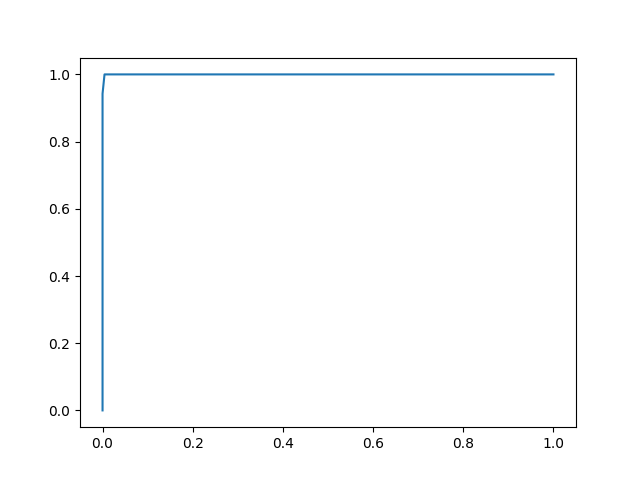

In [208]:
%%python
import pandas as pd
import matplotlib.pyplot as plt
import tempfile
from IPython.display import Image

roc = spark.sql("select * from roc")
rocPandas = roc.toPandas()
print(rocPandas.head())
plt.clf()
plt.plot(rocPandas['FPR'],rocPandas['TPR'])
with tempfile.NamedTemporaryFile(suffix=".png") as fo:
    plt.savefig(fo.name)
    retval = Image(filename=fo.name)

## Prediction on test set

In [209]:
val prediction = lrModel.transform(testData)

prediction: org.apache.spark.sql.DataFrame = [loan_amnt: int, term: string ... 104 more fields]


## Evaluation

In [189]:
def evaluatePrediction(prediction: DataFrame) = {
    prediction.createOrReplaceTempView("prediction")
    
    spark.sql("""
select label,prediction,count(1) from prediction group by label,prediction
""").show(false)
    
    spark.sql("""
select 
(TP+TN)/(P+N) as Accuracy,
TP/(TP+FP) as Precision,
TP/(TP+FN) as Recall,
2*TP/(2*TP+FP+FN) as F1
from (
    select 
    count(1) as total, 
    sum(case when label = 1 and prediction = 1 then 1 else 0 end) as TP,
    sum(case when label = 0 and prediction = 0 then 1 else 0 end) as TN,
    sum(case when label = 0 and prediction = 1 then 1 else 0 end) as FP,
    sum(case when label = 1 and prediction = 0 then 1 else 0 end) as FN,
    sum(case when label = 1 then 1 else 0 end) as P,
    sum(case when label = 0 then 1 else 0 end) as N
    from prediction
    )
""").show(false)
}

evaluatePrediction: (prediction: org.apache.spark.sql.DataFrame)Unit


In [210]:
evaluatePrediction(prediction)

+-----+----------+--------+
|label|prediction|count(1)|
+-----+----------+--------+
|0    |0.0       |1786    |
|1    |1.0       |211     |
+-----+----------+--------+

+--------+---------+------+---+
|Accuracy|Precision|Recall|F1 |
+--------+---------+------+---+
|1.0     |1.0      |1.0   |1.0|
+--------+---------+------+---+



# Decision Tree fitting

In [191]:
import org.apache.spark.ml.classification.DecisionTreeClassificationModel
import org.apache.spark.ml.classification.DecisionTreeClassifier
import org.apache.spark.ml.evaluation.MulticlassClassificationEvaluator

val dt = new DecisionTreeClassifier()
  .setLabelCol("label")
  .setFeaturesCol("features")

import org.apache.spark.ml.classification.DecisionTreeClassificationModel
import org.apache.spark.ml.classification.DecisionTreeClassifier
import org.apache.spark.ml.evaluation.MulticlassClassificationEvaluator
dt: org.apache.spark.ml.classification.DecisionTreeClassifier = dtc_07c32a49c1e9


In [192]:
val model = dt.fit(trainingData)
val prediction = model.transform(testData)

2019-06-04 11:40:16,677 WARN  [Executor task launch worker for task 2330] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_2706_1 in memory! (computed 140.4 MB so far)
2019-06-04 11:40:16,677 WARN  [Executor task launch worker for task 2330] storage.BlockManager (Logging.scala:logWarning(66)) - Persisting block rdd_2706_1 to disk instead.
2019-06-04 11:40:18,338 WARN  [Executor task launch worker for task 2329] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_2706_0 in memory! (computed 210.9 MB so far)
2019-06-04 11:40:18,338 WARN  [Executor task launch worker for task 2329] storage.BlockManager (Logging.scala:logWarning(66)) - Persisting block rdd_2706_0 to disk instead.
2019-06-04 11:40:20,769 WARN  [Executor task launch worker for task 2330] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_2706_1 in memory! (computed 210.9 MB so far)
2019-06-04 11:40:24,115 WARN  [Executor task launch

model: org.apache.spark.ml.classification.DecisionTreeClassificationModel = DecisionTreeClassificationModel (uid=dtc_07c32a49c1e9) of depth 1 with 3 nodes
prediction: org.apache.spark.sql.DataFrame = [loan_amnt: int, term: string ... 104 more fields]


In [193]:
evaluatePrediction(prediction)

+-----+----------+--------+
|label|prediction|count(1)|
+-----+----------+--------+
|0    |0.0       |1786    |
|1    |1.0       |211     |
+-----+----------+--------+

+--------+---------+------+---+
|Accuracy|Precision|Recall|F1 |
+--------+---------+------+---+
|1.0     |1.0      |1.0   |1.0|
+--------+---------+------+---+



# Random Forest fitting

In [146]:
import org.apache.spark.ml.classification.{RandomForestClassificationModel, RandomForestClassifier}
import org.apache.spark.ml.evaluation.MulticlassClassificationEvaluator

import org.apache.spark.ml.classification.{RandomForestClassificationModel, RandomForestClassifier}
import org.apache.spark.ml.evaluation.MulticlassClassificationEvaluator


In [200]:
val rf = new RandomForestClassifier()
  .setLabelCol("label")
  .setFeaturesCol("features")
  .setNumTrees(100)

rf: org.apache.spark.ml.classification.RandomForestClassifier = rfc_765948292ea5


In [201]:
val model = rf.fit(trainingData)
val prediction = model.transform(testData)

2019-06-04 11:43:08,874 WARN  [Executor task launch worker for task 3021] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_3093_1 in memory! (computed 142.9 MB so far)
2019-06-04 11:43:08,874 WARN  [Executor task launch worker for task 3021] storage.BlockManager (Logging.scala:logWarning(66)) - Persisting block rdd_3093_1 to disk instead.
2019-06-04 11:43:10,710 WARN  [Executor task launch worker for task 3020] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_3093_0 in memory! (computed 214.8 MB so far)
2019-06-04 11:43:10,711 WARN  [Executor task launch worker for task 3020] storage.BlockManager (Logging.scala:logWarning(66)) - Persisting block rdd_3093_0 to disk instead.
2019-06-04 11:43:12,484 WARN  [Executor task launch worker for task 3021] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_3093_1 in memory! (computed 214.8 MB so far)
2019-06-04 11:43:15,942 WARN  [Executor task launch

model: org.apache.spark.ml.classification.RandomForestClassificationModel = RandomForestClassificationModel (uid=rfc_765948292ea5) with 100 trees
prediction: org.apache.spark.sql.DataFrame = [loan_amnt: int, term: string ... 104 more fields]


In [202]:
evaluatePrediction(prediction)

+-----+----------+--------+
|label|prediction|count(1)|
+-----+----------+--------+
|1    |0.0       |211     |
|0    |0.0       |1786    |
+-----+----------+--------+

+------------------+---------+------+---+
|Accuracy          |Precision|Recall|F1 |
+------------------+---------+------+---+
|0.8943415122684026|null     |0.0   |0.0|
+------------------+---------+------+---+

